## Inference

In [124]:
# Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# StarDist
from stardist.models import StarDist2D, Config2D
from stardist.plot import render_label
from csbdeep.utils import normalize

In [61]:
# Check if GPU is available
print("GPU: " + str(len(tf.config.list_physical_devices('GPU')) > 0))
print("TensorFlow: " + str(tf.__version__))

GPU: True
TensorFlow: 2.13.0


In [62]:
# Import WSI images
img_array = np.load('data/Challenge/images.npy')

In [63]:
# Amount of images (# of Images, Width, Height, Channels)
img_array.shape

(4981, 256, 256, 3)

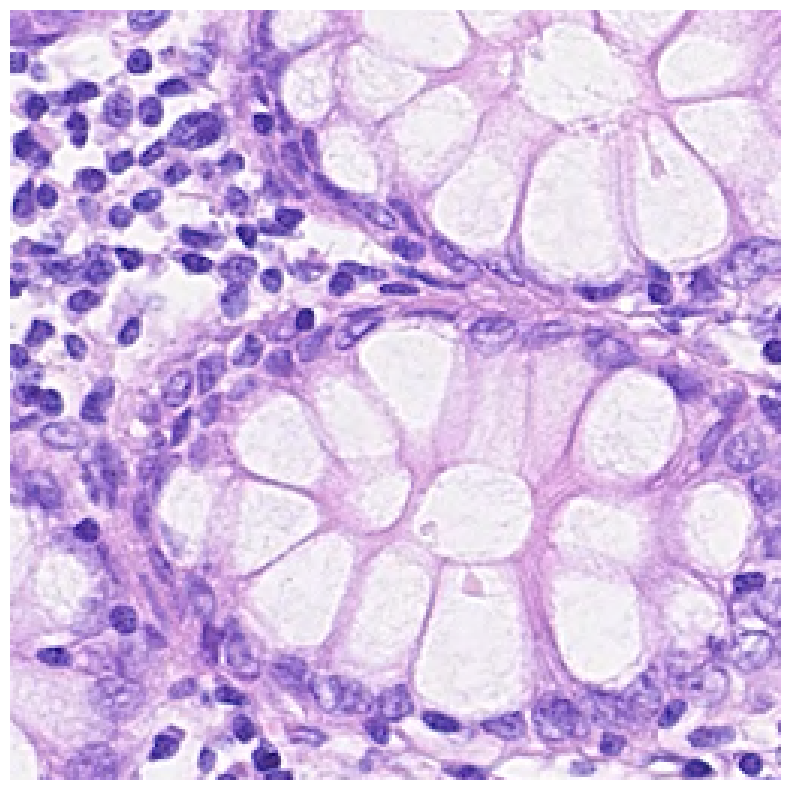

In [64]:
# Display test image:
plt.imshow(img_array[10])
plt.axis('off')
plt.show()

In [65]:
# Available models 
StarDist2D.from_pretrained() 

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None


In [66]:
# Define model
HE_model = StarDist2D.from_pretrained('2D_versatile_he')

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [67]:
# Assuming img_array is an array of 256x256 images
total_time = 0
num_images = len(img_array)

# Ensure that TensorFlow is using the GPU
with tf.device('/GPU:0'):
    for img in img_array:
        # Start timing
        start_time = time.time()
        # Process with StarDist
        he_labels, _ = HE_model.predict_instances(normalize(img))
        # End timing
        end_time = time.time()
        # Accumulate time
        total_time += end_time - start_time

2024-01-10 15:42:31.874889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [68]:
# Calculate average time taken per image
average_time_per_image = total_time / num_images
print(f"Average time taken per 256x256 image: {average_time_per_image} seconds")

Average time taken per 256x256 image: 0.03737878311209304 seconds


In [69]:
# Time for a 100000x100000 image
pixels_small_image = 256 * 256  # Number of pixels in the small image
pixels_large_image = 100000 * 100000  # Number of pixels in the large image

# Scaling the time based on the number of pixels
time_large_image = average_time_per_image * (pixels_large_image / pixels_small_image)

# Output the estimated time for the larger image
print(f"Estimated time for processing a 100000x100000 image: {time_large_image} seconds or {time_large_image / 60 / 60} hours")

Estimated time for processing a 100000x100000 image: 5703.54966920365 seconds or 1.5843193525565695 hours


In [87]:
# Single image
he_labels, _ = HE_model.predict_instances(normalize(img_array[900]))

Text(0.5, 1.0, 'Prediction')

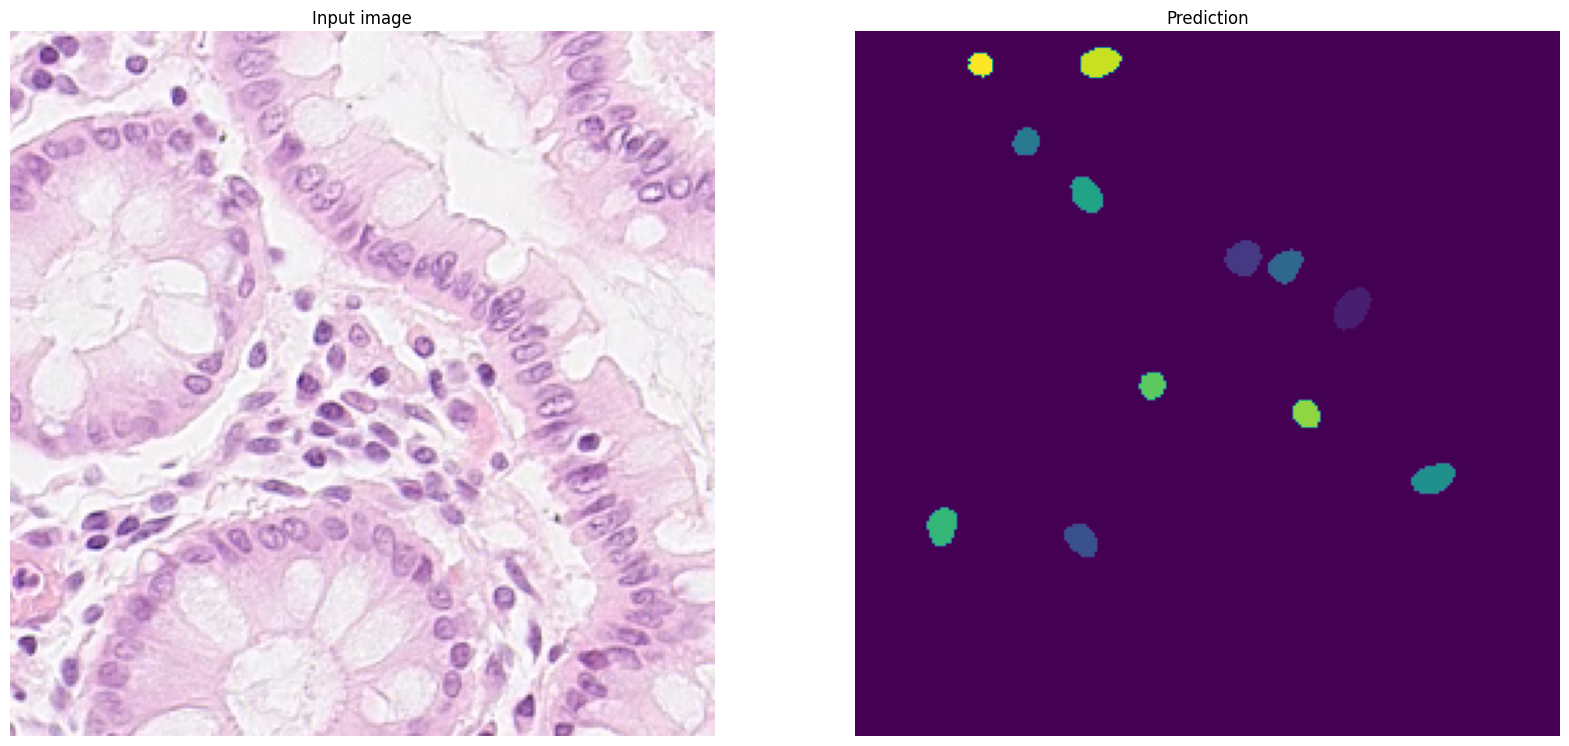

In [88]:
plt.rcParams["figure.figsize"] = (20,10)
plt.subplot(1,2,1)
plt.imshow(img_array[900], cmap="gray")
plt.axis("off")
plt.title("Input image")

plt.subplot(1,2,2)
plt.imshow(he_labels)
plt.axis("off")
plt.title("Prediction")

## Training

In [128]:
# Imports
from sklearn.model_selection import train_test_split
from stardist import fill_label_holes, random_label_cmap, calculate_extents
import sys
from tqdm import tqdm
np.random.seed(42)
lbl_cmap = random_label_cmap()

In [103]:
# Load images and labels
x = np.load('data/Challenge/images.npy')
y = np.load('data/Challenge/labels.npy')

In [107]:
#Normalize input images and fill holes in masks
axis_norm = (0,1)   # normalize channels independently
n_channel = 1 if x[0].ndim == 2 else x[0].shape[-1]  # determine number of channels
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(x)]
Y = [fill_label_holes(y) for y in tqdm(y)]

Normalizing image channels independently.


100%|██████████| 4981/4981 [01:08<00:00, 72.38it/s] 


In [108]:
# Split into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(x, y, test_size=0.2, random_state=42)
print('number of images: %3d' % len(x))
print('- training:       %3d' % len(X_train))
print('- validation:     %3d' % len(X_val))

number of images: 4981
- training:       3984
- validation:     997


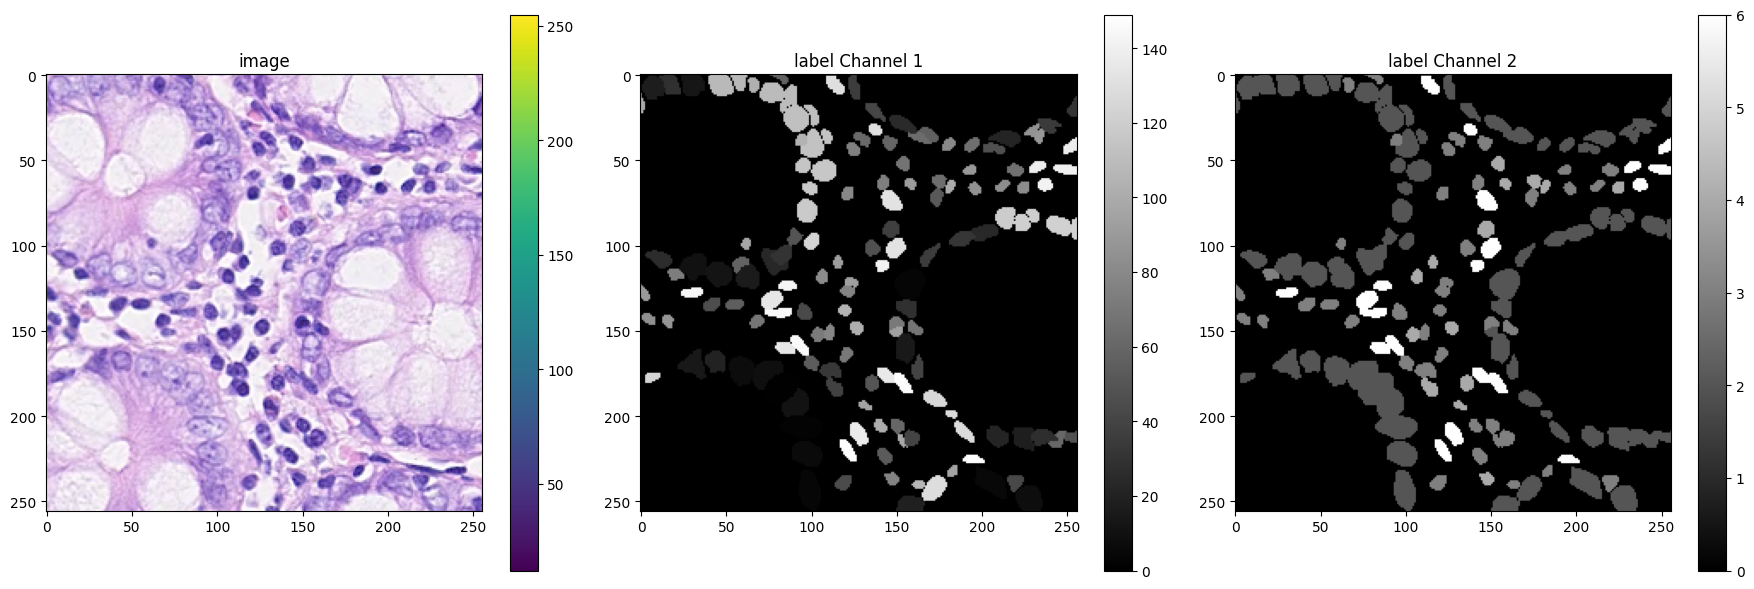

In [123]:
# Function to plot an individual channel
def plot_channel(img, title, ax, fig, cmap='gray'):
    im = ax.imshow(img, cmap=cmap)
    ax.set_title(title)
    fig.colorbar(im, ax=ax)

# Function to plot image and its corresponding label
def plot_img_label(img, lbl, img_title="image", lbl_title="label"):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Adjust for 3 subplots

    # Plot the image
    if img.ndim == 2 or img.shape[-1] == 1:
        # Grayscale image
        plot_channel(img, img_title, axs[0], fig, cmap='gray')
    elif img.shape[-1] == 3:
        # RGB image
        plot_channel(img, img_title, axs[0], fig, cmap=None)

    # Plot each channel of the label separately
    for i in range(2):
        plot_channel(lbl[..., i], f"{lbl_title} Channel {i+1}", axs[i+1], fig)

    plt.tight_layout()

# Example usage
i = min(9, len(x)-1)
img, lbl = x[i], y[i]
assert img.ndim in (2,3)
img = img if (img.ndim == 2 or img.shape[-1] == 3) else img[..., 0]
plot_img_label(img, lbl)